Data: http://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/vowel/

https://sci2s.ugr.es/keel/dataset.php?cod=113

* Thinking of a problem that's interesting for you and finding a dataset for that
* Describing this problem and explaining how a model could be used
* Preparing the data and doing EDA, analyzing important features
* Training multiple models, tuning their performance and selecting the best model
* Exporting the notebook into a script
* Putting your model into a web service and deploying it locally with docker
* Bonus points for deploying the service to the cloud

In [689]:
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_rows', 200)


In [690]:
df = pd.read_csv('vowels_data.csv')

In [691]:
df.drop(columns = "train_test", inplace = True)

In [692]:
df.head()

,speaker,sex,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,vowel
0,0,0,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814,0
1,0,0,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488,1
2,0,0,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049,2
3,0,0,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795,3
4,0,0,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396,4


In [693]:
df.dtypes

speaker      int64
sex          int64
f0         float64
f1         float64
f2         float64
f3         float64
f4         float64
f5         float64
f6         float64
f7         float64
f8         float64
f9         float64
vowel        int64
dtype: object

<AxesSubplot:>

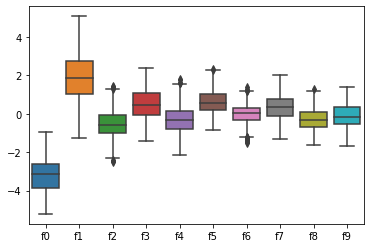

In [694]:
sns.boxplot(data = df[['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9']])

It's tricky to know how to split the data for train/val/test. Although I have 990 rows of data, they are only spoken by 15 people, and it is reasonable to think that the person speaking is likely to have a significant impact on the data.

If I were to split the 990 rows randomly, I would have data leakage from the test data into the training data, since some of the training data would come from the same people who also produced test data.

Therefore I decided to split off the test data according to people. I chose two male and two female speakers to constitute the test data.

I considered whether or not I should take a similar approach for the validation data. In the end I decided to use a manual cross-validation, where I held back one person from the training data each time to be used for validation, and then took the mean of the evaluation metrics.

In [695]:
from sklearn.model_selection import train_test_split

In [696]:
df_test = df[df.speaker.isin([10, 11, 13, 14])]  # Two male and two female in df_test

In [697]:
# df_train, df_val = train_test_split(df[df.speaker.isin([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12])], test_size = 0.25)

In [721]:
# df_val = df[df.speaker.isin([9, 12])]
df_train = df[df.speaker.isin([0,1,2,3,4,5,6,7,8,9,12])]

In [722]:
len(df_train), len(df_test)

(726, 132, 264)

In [700]:
df_train = df_train.reset_index(drop=True)

In [701]:
# df_val = df_val.reset_index(drop=True)

In [702]:
df_test = df_test.reset_index(drop=True)

In [703]:
y_train = df_train.vowel

In [704]:
# y_val = df_val.vowel

In [705]:
y_test = df_test.vowel

In [706]:
del df_train['vowel']
# del df_val['vowel']
del df_test['vowel']

In [707]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

Try just doing one class - whether the vowel is 0 or not

In [708]:
len(y_train)

594

In [709]:
lr = LogisticRegression(multi_class="multinomial", C=500, max_iter = 100)
lr.fit(df_train, y_train)

/home/mark/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=500, multi_class='multinomial')

In [710]:
# y_preds = lr.predict_proba(df_val)

In [711]:
# (y_preds == y_val).mean()

0.0

In [712]:
# y_preds

array([[9.95223213e-01, 4.76239030e-03, 1.31371532e-05, ...,
        1.40330429e-09, 2.12580658e-09, 1.25641434e-06],
       [2.11220228e-01, 6.78092668e-02, 2.96582841e-01, ...,
        3.93903190e-05, 1.09950430e-04, 4.20147480e-01],
       [2.77402265e-13, 2.54816748e-11, 1.41123046e-06, ...,
        1.90020988e-13, 7.52097292e-17, 2.64854167e-07],
       ...,
       [8.24816056e-14, 8.22805554e-10, 5.51049677e-08, ...,
        7.88377633e-02, 7.13500999e-05, 4.26369023e-01],
       [1.54384899e-15, 1.32099890e-10, 6.90749903e-11, ...,
        1.49098447e-02, 2.66340626e-06, 3.62812456e-01],
       [1.60983575e-14, 1.65613955e-08, 5.93500998e-06, ...,
        7.11628965e-04, 7.17316735e-08, 4.88906414e-02]])

In [714]:
df_train['speaker'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [715]:
def evaluate_model(model):
    speakers = df_train['speaker'].unique()
    model.fit(df_train, y_train)
    y_preds = model.predict_proba(df_val)
    return roc_auc_score(y_val, y_preds, multi_class='ovo')

In [716]:
evaluate_model(lr)

/home/mark/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8534722222222223

In [717]:
rf = RandomForestClassifier()

In [718]:
evaluate_model(rf)

0.9317234848484849

In [719]:
gb = GradientBoostingClassifier()

In [720]:
evaluate_model(gb)

0.8775252525252527

## Multi-class classification with Random Forest and Gradient Boosting